# Бонусное домашнее задание

## Part 0

В данном домашнем задании вам предстоит реализовать СLIP -- self-supervision модель которая выучивает зависимости между картинками и текстов в едином векторном пространстве. Для выполнения этого домашнего задания вам понадобится GPU и несколько дополнительных библиотек. Автор рекомендует делать все исключительно в Kaggle. 


[Ссылка на датасет](https://www.kaggle.com/datasets/keenwarrior/small-flicker-data-for-image-captioning)

[Ссылка на статью](https://openai.com/research/clip)

Задания в ноутбуке будут во многом опираться на статью, поэтому рекомендуется ее прочитать перед выполнением.

In [1]:
# !pip install timm
# !pip install transformers

In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
import timm
PATH_TO_IMAGES = "./flickr1k/captions.csv"

## Part 1 (8 баллов)

Для начала нам нужно реализовать составляющие модели: Кодировщик картинок, текста и проектор на какое-то маломерное пространство. В папке с заданием есть соответствующие файлы, заполните пропуски в них опираясь на docstring-и.

Разбалловка следующая: 

Правильно реализованные кодировщики: 2 балла.

Правильно реализованный проектор: 2 балла.

Правильно реализованный класс СLIP: 4 балла.

In [2]:
from CLIPDataset import CLIPDataset
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from ImageEncoder import ImageEncoder
from ProjectionHead import ProjectionHead
from TextEncoder import TextEncoder

In [3]:
class CLIP(nn.Module):
    def __init__(self, image_embedding=2048, text_embedding=768, projection_dim=256,
        temp_init=1.0):
        super().__init__()
        self.image_encoder = ImageEncoder(
            model_name="resnet50", 
            pretrained=True, 
            trainable=False
        )
        self.text_encoder = TextEncoder(
            model_name="distilbert-base-uncased", 
            pretrained=True, 
            trainable=False
        )
        
        self.image_projections = ProjectionHead(
            embedding_dim=image_embedding, 
            projection_dim=projection_dim
        )
        self.text_projections = ProjectionHead(
            embedding_dim=text_embedding, 
            projection_dim=projection_dim
        )
        
        self.logit_scale = nn.Parameter(torch.ones([]) * temp_init)
    def forward(self, batch):
        """
        :batch: dict of images and text
        Here is what you should do:
        1) extract image and text features from batch
        2) project features into projection space (small latent space)
        3) compute cosine similarity with temperature this will be your logits
        4) compute "true" logits (eg. cosine similarity between images and images, text and text)
        5) create targets by averaging similarities from step above (do not forget about temperature)
        6) compute mean loss (see paper)
        7) return loss

        Overall: read paper.
        
        """
        images = batch["image"]
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        
        img_features = self.image_encoder(images)
        txt_features = self.text_encoder(input_ids, attention_mask)
        
        img_embeds = self.image_projections(img_features)
        txt_embeds = self.text_projections(txt_features)

        img_embeds = img_embeds / img_embeds.norm(dim=-1, keepdim=True)
        txt_embeds = txt_embeds / txt_embeds.norm(dim=-1, keepdim=True)
        
        scale = torch.exp(self.logit_scale)
        logits_per_image = img_embeds @ txt_embeds.t() * scale
        logits_per_text  = txt_embeds @ img_embeds.t() * scale
        
        batch_size = images.shape[0]
        labels = torch.arange(batch_size, device=images.device)
        loss_img = nn.functional.cross_entropy(logits_per_image, labels)
        loss_txt = nn.functional.cross_entropy(logits_per_text, labels)
        
        loss = (loss_img + loss_txt) / 2.0
        return loss
    

def CE(preds, targets):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    return loss   

# Part 2. (0 Баллов)

Здесь вам нужно вписать правильный путь до csv файла на своей машине и запустить код.

In [4]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{PATH_TO_IMAGES}")
    dataframe["id"] = np.array(list(dataframe.index))
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe

In [5]:
def build_loaders(dataframe, tokenizer, mode):
    dataset = CLIPDataset(
        image_path="./flickr1k/images",
        image_filenames=dataframe["image"].values,
        captions=dataframe["caption"].values,
        tokenizer=tokenizer
    )
    dataloader = DataLoader(
        dataset,
        batch_size=64,
        num_workers=1,
        shuffle=True if mode == "train" else False,
    )
    return dataloader, dataset

In [6]:
class AvgMeter:
    def __init__(self, name="CrossEntropyLoss"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text
    
    def __format__(self, formatspec):
        text = f"{self.name}: {format(self.avg, formatspec)}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [7]:
def train(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    for batch in tqdm(train_loader, desc="Training", total=len(train_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

@torch.no_grad()
def validate(model, validation_loader):
    loss_meter = AvgMeter()
    for batch in tqdm(validation_loader, desc="Validating", total=len(validation_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        loss = model(batch)
        loss_meter.update(loss.item(), batch["image"].shape[0])
    return loss_meter

## Part 3. (2 балла)

За вас написан минимальный код для обучения, если он запускается и модель учится, то за этот пункт вы получите 0.5 балла. Чтобы получить полный балл за задание вам нужно будет провести несколько экспериментов и поподбирать гиперпараметры. Можно начать со статьи.

In [39]:
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10
def procedure():
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
    model = CLIP().to(device)
    params = [{"params": model.image_encoder.parameters()}, 
              {"params" : model.text_encoder.parameters()},
              {"params" : itertools.chain(model.image_projections.parameters(),
                                          model.text_projections.parameters())}]
    optimizer = torch.optim.Adam(params)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1, factor=0.8)
    step="epoch"
    for epoch in range(EPOCH):
        print(f"Epoch: {epoch}. Train and Validation in progress...")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        val_loss = validate(model, val_loader)
        
        lr_scheduler.step(val_loss.avg)
        print(f"Epoch: {epoch},", end="\n")
        print(f"Train loss: {train_loss:0.3f}", end="\n")
        print(f"Validation loss: {val_loss:0.3f}")
    return model

In [40]:
model = procedure()

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 0,
Train loss: CrossEntropyLoss: 2.645
Validation loss: CrossEntropyLoss: 2.354
Epoch: 1. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 1,
Train loss: CrossEntropyLoss: 2.229
Validation loss: CrossEntropyLoss: 2.217
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 2,
Train loss: CrossEntropyLoss: 2.093
Validation loss: CrossEntropyLoss: 2.100
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 3,
Train loss: CrossEntropyLoss: 2.011
Validation loss: CrossEntropyLoss: 2.073
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 4,
Train loss: CrossEntropyLoss: 1.961
Validation loss: CrossEntropyLoss: 2.048
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 5,
Train loss: CrossEntropyLoss: 1.939
Validation loss: CrossEntropyLoss: 2.017
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 6,
Train loss: CrossEntropyLoss: 1.894
Validation loss: CrossEntropyLoss: 1.989
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 7,
Train loss: CrossEntropyLoss: 1.868
Validation loss: CrossEntropyLoss: 1.992
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 8,
Train loss: CrossEntropyLoss: 1.848
Validation loss: CrossEntropyLoss: 1.961
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/125 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Validating:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


Epoch: 9,
Train loss: CrossEntropyLoss: 1.824
Validation loss: CrossEntropyLoss: 1.948


## Part 4 (0 баллов)

Просто посмотрим на результаты.

In [49]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        image_features = model.image_encoder(batch["image"]).to(device)

        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

In [53]:
PATH_TO_IMAGE_FOLDER = "/Users/vadim/Downloads/HW-CLIP/flickr1k/images"


In [54]:
import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGE_FOLDER}" + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()
    

In [55]:
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/32 [00:00<?, ?it/s]

/Users/vadim/Downloads/HW-CLIP/CLIPDataset.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  key: torch.tensor(values[idx]) for key, values in self.encoded_captions.items()


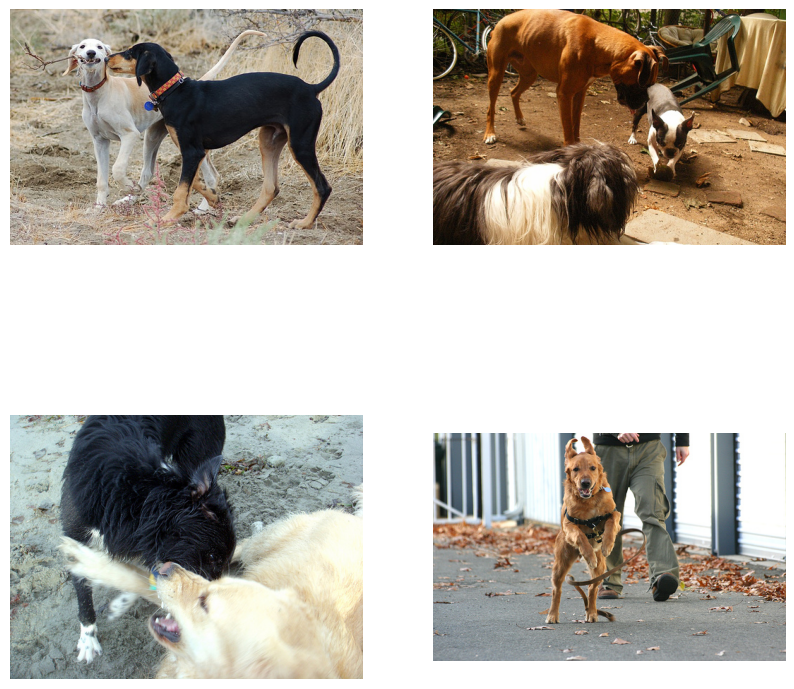

In [56]:
find_match(model, image_embeddings, "dogs", valid_df["image"].values)

## Опишите свои результаты.

Модель подобрала четыре фотографии, на которых действительно изображены собаки. Все результаты соответствуют запросу «dogs» и выглядят вполне уместно.

## Эксперимент 2

В первом эксперименте лосс на первой эпохе получился низким и потом медленно снижался, в конце даже стал переобучаться.

Во втором эксперименте я изменил несколько важных настроек, чтобы обучение модели проходило стабильнее. Сначала я перешёл от оптимизатора Adam к AdamW и установил скорость обучения на 1e-4 вместо более высокой скорости по умолчанию. AdamW, в отличие от обычного Adam, установил weight decay равный 1e-5, что помогает избежать переобучения. Вместо адаптивного планировщика ReduceLROnPlateau, который меняет скорость обучения в зависимости от улучшения на валидационной выборке я использовал StepLR. Он просто уменьшает скорость обучения в два раза каждые пять эпох. Чтобы лучше дообучиться на данных.

In [8]:
import itertools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10
LEARNING_RATE = 1e-4

def procedure():
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")
    model = CLIP().to(device)
    params = [{"params": model.image_encoder.parameters()}, 
              {"params" : model.text_encoder.parameters()},
              {"params" : itertools.chain(model.image_projections.parameters(),
                                          model.text_projections.parameters())}]
    optimizer = torch.optim.Adam(params)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    step="epoch"
    for epoch in range(EPOCH):
        print(f"Epoch: {epoch}. Train and Validation in progress...")
        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        val_loss = validate(model, val_loader)
        
        lr_scheduler.step(val_loss.avg)
        print(f"Epoch: {epoch},", end="\n")
        print(f"Train loss: {train_loss:0.3f}", end="\n")
        print(f"Validation loss: {val_loss:0.3f}")
    return model

In [9]:
model = procedure()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

c:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tom\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

c:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Tom\.cache\huggingface\hub\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 0. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 0,
Train loss: CrossEntropyLoss: 3.941
Validation loss: CrossEntropyLoss: 3.535
Epoch: 1. Train and Validation in progress...


c:\Users\Tom\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1,
Train loss: CrossEntropyLoss: 3.428
Validation loss: CrossEntropyLoss: 3.220
Epoch: 2. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2,
Train loss: CrossEntropyLoss: 3.195
Validation loss: CrossEntropyLoss: 3.087
Epoch: 3. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3,
Train loss: CrossEntropyLoss: 3.052
Validation loss: CrossEntropyLoss: 2.986
Epoch: 4. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4,
Train loss: CrossEntropyLoss: 2.953
Validation loss: CrossEntropyLoss: 2.908
Epoch: 5. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5,
Train loss: CrossEntropyLoss: 2.867
Validation loss: CrossEntropyLoss: 2.859
Epoch: 6. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6,
Train loss: CrossEntropyLoss: 2.801
Validation loss: CrossEntropyLoss: 2.802
Epoch: 7. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7,
Train loss: CrossEntropyLoss: 2.749
Validation loss: CrossEntropyLoss: 2.758
Epoch: 8. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8,
Train loss: CrossEntropyLoss: 2.697
Validation loss: CrossEntropyLoss: 2.730
Epoch: 9. Train and Validation in progress...


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9,
Train loss: CrossEntropyLoss: 2.650
Validation loss: CrossEntropyLoss: 2.688


Лосс получился больше, поскольку изначально на первой эпохе он был высок и не смог серьезно снизиться за 10 эпох.

In [14]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        image_features = model.image_encoder(batch["image"]).to(device)

        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

PATH_TO_IMAGE_FOLDER = "./flickr1k/images"

import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGE_FOLDER}" + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()
    
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

In [15]:
find_match(model, image_embeddings, "dogs", valid_df["image"].values)

Однако несмотря на это картинки все равно соответствуют промпту.

## Эксперимент 3

В третьем эксперименте я задал начальное значение температуры равное 2.66, а также разморозил последние слои предобученного ResNet (блок layer4) и DistilBERT (слои 4 и 5), чтобы позволить модели тонко настроиться на данные. Кроме того, я снизил скорость обучения до 5e-5 с weight_decay=1e-5 и использовал шаговый планировщик, что должно обеспечить более стабильное и аккуратное обучение по сравнению со вторым экспериментом.

In [27]:
import itertools
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from transformers import DistilBertTokenizer
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCH = 10
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-5
STEP_SIZE = 5
GAMMA = 0.5 

def procedure():
    train_df, validation_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    train_loader, _ = build_loaders(train_df, tokenizer, mode="train")
    val_loader, _ = build_loaders(validation_df, tokenizer, mode="valid")

    model = CLIP(
        temp_init=2.66
    ).to(device)

    for name, param in model.image_encoder.model.named_parameters():
        if "layer4" in name:
            param.requires_grad = True
    
    for name, param in model.text_encoder.model.named_parameters():
        if "layer.4." in name or "layer.5." in name:
            param.requires_grad = True

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

    for epoch in range(1, EPOCH + 1):
        print(f"Epoch {epoch}/{EPOCH}")

        model.train()
        train_loss = train(model, train_loader, optimizer, lr_scheduler, step="epoch")
        model.eval()
        val_loss = validate(model, val_loader)
        
        print(f"Train Loss: {train_loss.avg:.4f}, Validation Loss: {val_loss.avg:.4f}")

    return model

In [28]:
model = procedure()

Epoch 1/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 3.4253, Validation Loss: 2.4992
Epoch 2/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.9750, Validation Loss: 1.8017
Epoch 3/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 1.2637, Validation Loss: 1.4960
Epoch 4/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.9043, Validation Loss: 1.3238
Epoch 5/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.6717, Validation Loss: 1.2149
Epoch 6/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.5253, Validation Loss: 1.1504
Epoch 7/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.4199, Validation Loss: 1.1005
Epoch 8/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3621, Validation Loss: 1.0764
Epoch 9/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.3060, Validation Loss: 1.0429
Epoch 10/10


Training:   0%|          | 0/63 [00:00<?, ?it/s]

Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Train Loss: 0.2630, Validation Loss: 1.0399


Как и предполагалось разморозка  слоев помогла модели дообучиться и я получил хороший результат в  виде 1.03 лосс на валидации.

In [29]:
@torch.inference_mode()
def get_image_embeddings(valid_df, model):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    valid_loader, _ = build_loaders(valid_df, tokenizer, mode="valid")
    valid_image_embeddings = []
    for batch in tqdm(valid_loader, desc="Getting embeddings", total=len(valid_loader)):
        batch = {key: value.to(device) for key, value in batch.items() if key != "caption"}
        image_features = model.image_encoder(batch["image"]).to(device)

        image_embeddings = model.image_projections(image_features)
        valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)

PATH_TO_IMAGE_FOLDER = "./flickr1k/images"

import matplotlib.pyplot as plt
@torch.inference_mode()
def find_match(model, image_embeddings, text, image_filenames, num_examples=4):
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    text_encoded = tokenizer([text])
    batch = {key : torch.tensor(value).to(device) for key, value in text_encoded.items()}
    
    text_features = model.text_encoder(batch["input_ids"], batch["attention_mask"])
    text_embeddings = model.text_projections(text_features)
    
    norm_image_embeddings = nn.functional.normalize(image_embeddings, p=2, dim=-1)
    norm_text_embeddings = nn.functional.normalize(text_embeddings, p=2, dim=-1)
    
    similarity = norm_text_embeddings @ norm_image_embeddings.T
    
    ans, ans_index = torch.topk(similarity.squeeze(0), num_examples * 5)
    match = [image_filenames[index] for index in ans_index[::5]]
    fig, ax = plt.subplots(int(num_examples/2), int(num_examples/2), figsize= (10, 10))
    for m, a in zip(match, ax.flatten()):
        image = Image.open(f"{PATH_TO_IMAGE_FOLDER}" + f"/{m}")
        image = image.convert("RGB")
        a.imshow(image)
        a.axis("off")
    plt.show()
    
_, valid_df = make_train_valid_dfs()
image_embeddings = get_image_embeddings(valid_df, model)

Getting embeddings:   0%|          | 0/16 [00:00<?, ?it/s]

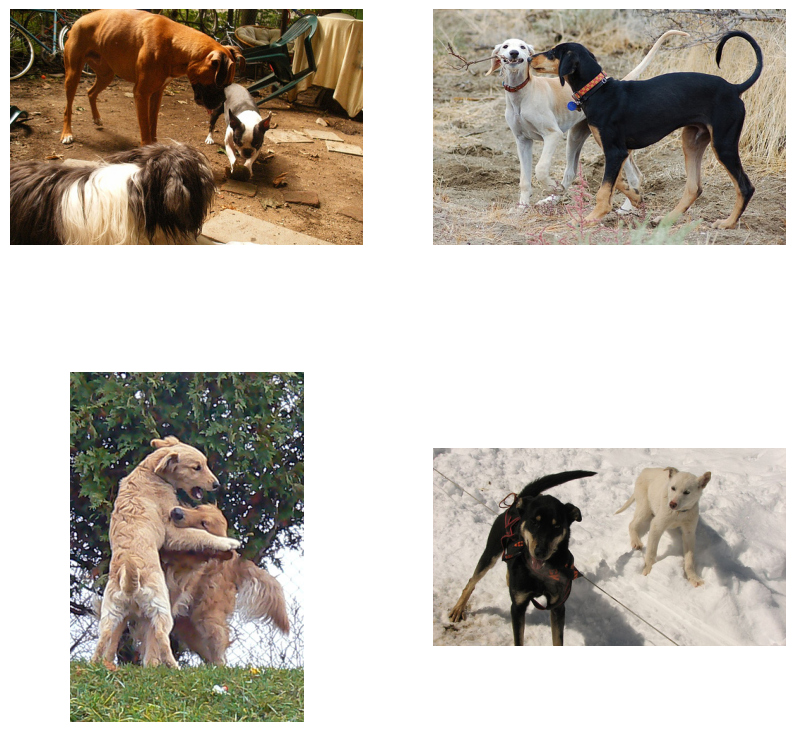

In [30]:
find_match(model, image_embeddings, "dogs", valid_df["image"].values)

In [33]:
find_match(model, image_embeddings, "car", valid_df["image"].values)

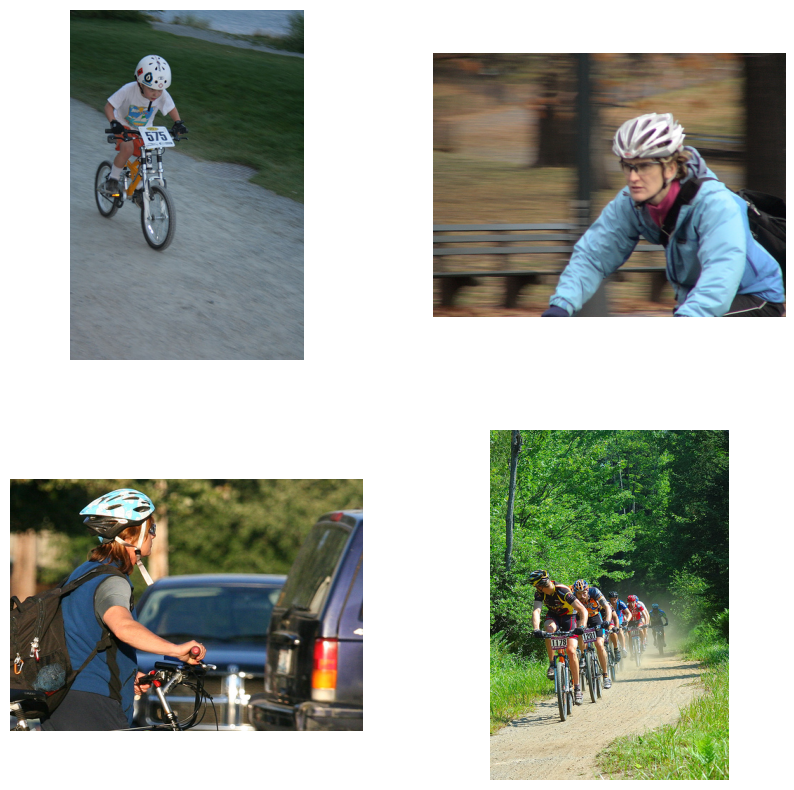

In [34]:
find_match(model, image_embeddings, "bike", valid_df["image"].values)

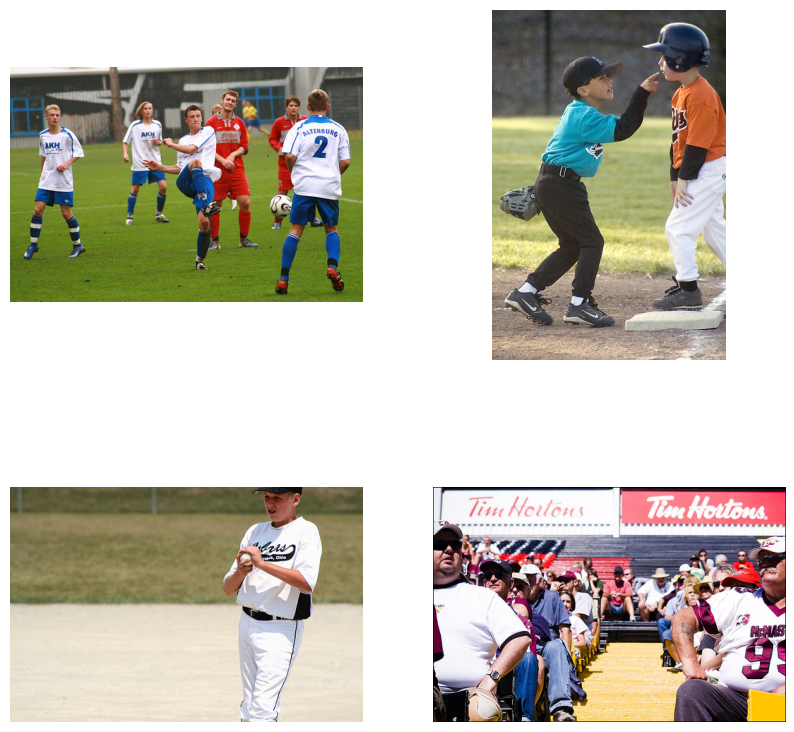

In [36]:
find_match(model, image_embeddings, "football", valid_df["image"].values)

Изображения также показывают хорошее соответствие промптам.